In [1]:
%load_ext autoreload
%autoreload 2

In [284]:
from sbi.inference import SNPE
from sbi.utils.support_posterior import PosteriorSupport
from sbi.utils import BoxUniform, posterior_nn
from sbi.analysis import pairplot

import torch
from torch import ones, zeros, as_tensor, eye, tensor, float32
from torch.distributions import MultivariateNormal

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle

In [281]:
prior = BoxUniform(-0.7*ones(1), 0.7*ones(1), device="cuda")

/home/michael/Documents/tsnpe_collection/sbi/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


In [282]:
def simulator(theta):
    return theta + torch.randn(theta.shape).to("cuda") * 0.2

In [283]:
_ = torch.manual_seed(0)
density_estimator = posterior_nn("nsf", num_bins=20)
inference = SNPE(prior, density_estimator=density_estimator, device="cuda")

proposal=prior
theta = proposal.sample((50_000,))
x = simulator(theta)
_ = inference.append_simulations(theta.to("cuda"), x.to("cuda")).train(training_batch_size=10_000)
posterior = inference.build_posterior().set_default_x(zeros(1, 1).to("cuda"))

 Neural network successfully converged after 256 epochs.

In [285]:
# with open("inference_r1_save.pkl", "wb") as handle:
#     pickle.dump(inference, handle)

/home/michael/Documents/tsnpe_collection/sbi/sbi/inference/base.py:449: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  warn(


In [287]:
x_vals = torch.linspace(-0.72, 0.72, 1000)

In [288]:
posterior_log_probs = posterior.log_prob(x_vals.unsqueeze(1).to("cuda"))
posterior_log_probs = posterior_log_probs.to("cpu")

In [228]:
gt_posterior = torch.distributions.Normal(0, 0.2)
gt_probs = torch.exp(gt_posterior.log_prob(x_vals))

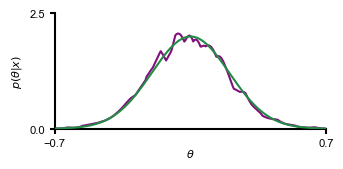

In [289]:
k_colors = ["#9ebcda", "#8c6bb1", "#810f7c", "#4d004b"]

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 1.5))
    ax.plot(x_vals.numpy(), gt_probs.numpy(), c="#238b45", zorder=1000)    
    ax.plot(x_vals.numpy(), posterior_log_probs.exp().numpy(), c=k_colors[2])
    
    ax.set_xlabel(r"$\theta$", labelpad=-1)
    ax.set_xticks([-0.7, 0.7])
    ax.set_xlim([-0.7, 0.7])
    ax.set_ylim([0, 2.5])
    ax.set_yticks([0, 2.5])
    ax.set_ylabel(r"$p(\theta | x)$")
    # plt.savefig("../svg/panel_sir_divergence.svg")

In [290]:
proposal = PosteriorSupport(prior, posterior, num_samples_to_estimate_support=100_000, allowed_false_negatives=0.1)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [291]:
pred = proposal.predict(x_vals.to("cuda").unsqueeze(1))

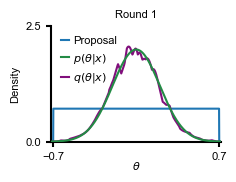

In [293]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2.2, 1.5))
    
    prior_probs = prior.log_prob(x_vals.unsqueeze(1).cuda())
    ax.plot(x_vals.numpy(), prior_probs.exp().cpu().numpy())
    
    ax.plot(x_vals.numpy(), gt_probs.numpy(), c="#238b45", zorder=1000)    
    ax.plot(x_vals.numpy(), posterior_log_probs.exp().numpy(), c=k_colors[2])
    
    ax.set_xlabel(r"$\theta$", labelpad=-1)
    ax.set_ylabel("Density")
    ax.legend(["Proposal", r"$p(\theta | x)$", r"$q(\theta | x)$"], loc="upper left", handlelength=0.7, handletextpad=0.4)
    ax.set_xticks([-0.7, 0.7])
    ax.set_xlim([-0.72, 0.72])
    ax.set_ylim([0, 2.5])
    ax.set_yticks([0, 2.5])
    ax.set_title("Round 1")
    plt.savefig("../svg/panel_a_failure.svg")

# Large epsilon

In [294]:
with open("inference_r1_save.pkl", "rb") as handle:
    inference = pickle.load(handle)

In [295]:
_ = torch.manual_seed(2)
theta = proposal.sample((50_000,))
x = simulator(theta)
_ = inference.append_simulations(theta.to("cuda"), x.to("cuda")).train(training_batch_size=10_000, force_first_round_loss=True)
posterior_r2 = inference.build_posterior().set_default_x(zeros(1, 1).to("cuda"))

The classifier rejected 52.9764% of all samples. You will get a speed-up of 112.7%.
 Neural network successfully converged after 165 epochs.

/home/michael/Documents/tsnpe_collection/sbi/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


In [297]:
posterior_log_probs_r2 = posterior_r2.log_prob(x_vals.unsqueeze(1).to("cuda"))
posterior_log_probs_r2 = posterior_log_probs_r2.to("cpu")

x_vals_ = torch.linspace(-0.7, 0.7, 1000)
proposal_probs = torch.sum(proposal.predict(x_vals_.unsqueeze(1).cuda())) / 1000
prior_val = prior_probs[100]
proposal_probs = proposal.predict(x_vals.unsqueeze(1).cuda()) * prior_val.exp() / proposal_probs

joint_probs = 0.5 * proposal_probs + 0.5 * prior_probs.exp()

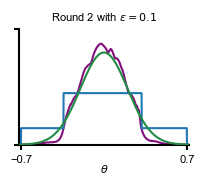

In [300]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2.2, 1.5))
    ax.plot(x_vals.numpy(), gt_probs.numpy(), c="#238b45", zorder=1000)    
    ax.plot(x_vals.numpy(), posterior_log_probs_r2.exp().numpy(), c=k_colors[2])
    ax.plot(x_vals.numpy(), joint_probs.cpu().numpy())
    
    ax.set_xlabel(r"$\theta$", labelpad=-1)
    ax.set_xticks([-0.7, 0.7])
    ax.set_xlim([-0.72, 0.72])
    ax.set_ylim([0, 2.5])
    ax.set_yticks([0, 2.5])
    ax.set_yticklabels([])
    ax.set_title("Round 2 with " + r"$\epsilon=0.1$")
    plt.savefig("../svg/panel_b_failure.svg")

# Small epsilon

In [303]:
with open("inference_r1_save.pkl", "rb") as handle:
    inference = pickle.load(handle)

In [346]:
proposal = PosteriorSupport(prior, posterior, num_samples_to_estimate_support=100_000, allowed_false_negatives=0.01)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [305]:
_ = torch.manual_seed(2)
theta = proposal.sample((50_000,))
x = simulator(theta)
_ = inference.append_simulations(theta.to("cuda"), x.to("cuda")).train(training_batch_size=10_000, force_first_round_loss=True)
posterior_r2 = inference.build_posterior().set_default_x(zeros(1, 1).to("cuda"))

The classifier rejected 25.2943% of all samples. You will get a speed-up of 33.9%.
 Neural network successfully converged after 114 epochs.

/home/michael/Documents/tsnpe_collection/sbi/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


In [306]:
posterior_log_probs_r2 = posterior_r2.log_prob(x_vals.unsqueeze(1).to("cuda"))
posterior_log_probs_r2 = posterior_log_probs_r2.to("cpu")

x_vals_ = torch.linspace(-0.7, 0.7, 1000)
proposal_probs = torch.sum(proposal.predict(x_vals_.unsqueeze(1).cuda())) / 1000
prior_val = prior_probs[100]
proposal_probs = proposal.predict(x_vals.unsqueeze(1).cuda()) * prior_val.exp() / proposal_probs

joint_probs = 0.5 * proposal_probs + 0.5 * prior_probs.exp()

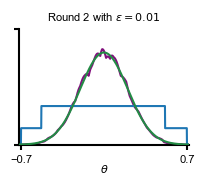

In [311]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2.2, 1.5))
    ax.plot(x_vals.numpy(), gt_probs.numpy(), c="#238b45", zorder=1000)    
    ax.plot(x_vals.numpy(), posterior_log_probs_r2.exp().numpy(), c=k_colors[2])
    ax.plot(x_vals.numpy(), joint_probs.cpu().numpy())
    
    ax.set_xlabel(r"$\theta$", labelpad=-1)
    ax.set_xticks([-0.7, 0.7])
    ax.set_xlim([-0.72, 0.72])
    ax.set_ylim([0, 2.5])
    ax.set_yticks([0, 2.5])
    ax.set_yticklabels([])
    ax.set_title("Round 2 with " + r"$\epsilon=0.01$")
    plt.savefig("../svg/panel_c_failure.svg")

In [356]:
vec = torch.linspace(0.4, 0.6, 1000)

In [357]:
posterior_log_probs_r2 = posterior_r2.log_prob(vec.unsqueeze(1).to("cuda"))
posterior_log_probs_r2 = posterior_log_probs_r2.to("cpu")
gt_probs = torch.exp(gt_posterior.log_prob(vec))

In [358]:
proposal_probs = torch.sum(proposal.predict(vec.unsqueeze(1).cuda())) / 1000
prior_val = prior_probs[100]
proposal_probs = proposal.predict(vec.unsqueeze(1).cuda()) * prior_val.exp() / proposal_probs
prior_probs = prior.log_prob(vec.unsqueeze(1).cuda())

joint_probs = 0.5 * proposal_probs + 0.5 * prior_probs.exp()

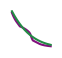

In [407]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(0.55, 0.5))
    ax.plot(vec.numpy(), gt_probs.numpy(), c="#238b45", zorder=1000)    
    ax.plot(vec.numpy(), posterior_log_probs_r2.exp().numpy(), c=k_colors[2])
    # ax.plot(vec.numpy(), joint_probs.cpu().numpy())

    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    plt.savefig("../svg/panel_d_failure.svg")

# Assemble

In [368]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [456]:
from svgutils.compose import *

svg_scale = 1.25

size = 40
x1 = 538
y1 = 68

kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
    
f = Figure("15.7cm", "4.2cm",
    Panel(
          SVG("../svg/panel_a_failure.svg").scale(svg_scale).move(0, 0),
        Text("a", 5, 19, **kwargs_text),
    ).move(-5, -5),
    Panel(
          SVG("../svg/panel_b_failure.svg").scale(svg_scale).move(0, 0),
        Text("b", -5, 19, **kwargs_text),
    ).move(220, -5),
    Panel(
          SVG("../svg/panel_c_failure.svg").scale(svg_scale).move(0, 0),
        Text("c", -5, 19, **kwargs_text),
    ).move(410, -5),
    Panel(
          SVG("../svg/panel_d_failure.svg").scale(svg_scale).move(0, 0),
    ).move(530, 20),
    

    Line(((x1,y1),(x1+size,y1)), width=1.5, color='grey'),
    Line(((x1,y1),(x1,y1-size)), width=1.5, color='grey'),
    Line(((x1,y1-size),(x1+size,y1-size)), width=1.5, color='grey'),
    Line(((x1+size,y1-size),(x1+size,y1)), width=1.5, color='grey'),
    
    Line(((x1,y1),(x1+12,y1+45)), width=1.5, color='grey'),
    Line(((x1+size,y1),(x1+size-12,y1+45)), width=1.5, color='grey'),
    
    Line(((x1+size-12,y1+55),(x1+size-12-16,y1+55)), width=1.5, color='grey'),
    Line(((x1+size-12,y1+45),(x1+size-12-16,y1+45)), width=1.5, color='grey'),
    Line(((x1+size-12,y1+45),(x1+size-12,y1+45+11)), width=1.5, color='grey'),
    Line(((x1+size-28,y1+45),(x1+size-28,y1+45+11)), width=1.5, color='grey'),
)

f.save("../fig/fig4_appendix_failure.svg")
svg('../fig/fig4_appendix_failure.svg')